# Monitoring the power in a single quantum dot

In these notes we will consider the seeming discrepancy arising between observed power in a single quantum dot.
The model is very simple and considers a single quantum dot, with energy $\epsilon$, weakly coupled to two reservoirs (which we will denote the hot and cold reservoir).
This can be modelled using the master equation and the denisty operator of the dot $\rho$
\begin{equation}
\frac{d \rho}{dt} = \left(\gamma_{H} f_{H}(\epsilon) + \gamma_{C} f_{C}(\epsilon)\right) \mathcal{D}[c^{\dagger}]\rho +  \left(\gamma_{H} (1-f_{H}(\epsilon)) + \gamma_{C} (1-f_{C}(\epsilon))\right) \mathcal{D}[c]\rho
\end{equation}
where $c$ is the operator of the dot, $\gamma_{\alpha}$ is the decay rate, $f_{\alpha}(\epsilon)$ is the Fermi-dirac distribution of baths with a given chemical potential $\mu_{\alpha}$ and temperature $T_{\alpha}$ given by 
\begin{equation}
f_{\alpha}(\epsilon) = \frac{1}{\exp\left(\frac{\epsilon - \mu_{\alpha}}{k_{B}T_{\alpha}}\right) + 1}\,,
\end{equation}
and $\mathcal{D}$ is the standard Lindblad disipator. 
One can easily show that the steadystate occupation of the dot $\langle n_{c} \rangle_{ss} = \langle c^{\dagger}c\rangle_{ss}$ is given by 
\begin{equation}
    \langle c^{\dagger}c \rangle_{ss} = \frac{\gamma_{H} f_{H}(\epsilon) + \gamma_{C} f_{C}(\epsilon)}{\gamma_{H} + \gamma_{C}}\,.
\end{equation}

Going forward we will assume there is a temperature gradient since $T_{C}<T_{H}$, but also a chemical potential gradient $\epsilon>\mu_{C}>\mu_{H}$.
The steady-state heat per unit time $\dot{Q}_{H}$ extracted from the hot lead, and the steady-state work per unit time (power) $\dot{W}$ performed by the device upon bringing electrons from the hot to the cold lead, are respectively given by
\begin{equation}
    \dot{Q}_{H} = (\epsilon - \mu_{H}) I_{H} \quad \dot{W} = (\mu_{L} - \mu_{R}) I_{H}\,,
\end{equation}
where $I_{H}$ is the particle current from the hot lead, which in the steadystate can be written in three diferent ways
\begin{align}
    I_{H} &= \frac{\gamma_{C}\gamma_{H}}{\gamma_{H}+\gamma_{C}}\left(f_{H}(\epsilon) - f_{C}(\epsilon)\right)\\
    &= \gamma_{H} f_{H}(\epsilon) \langle \hat{c}\hat{c}^{\dagger}\rangle_{ss} - \gamma_{H} (1 - f_{H}(\epsilon))\langle \hat{c}^{\dagger}\hat{c}\rangle_{ss} \\
    &= \gamma_{H}(f_{H}(\epsilon) - \langle \hat{c}^{\dagger}\hat{c}\rangle_{ss})\,.
\end{align}
Moreover, the entropy production is defined as 
\begin{equation}
    \sigma = (x_{C} - x_{H}) I_{H}\,, 
\end{equation}
where $x_{\alpha} = (\epsilon - \mu_{\alpha})/k_{B} T_{\alpha}$ are the exponents of the Fermi-Dirac distributions and otherwise called the 'scaled' barrier heights. 
So far this is completely uncontroversial and we can go ahead and simulate these statistics easily.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from FCS import *

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

def Fermi(ϵ, μ, T):
    return (np.exp((ϵ - μ)/T) + 1)**(-1) 

In [3]:
# ---- Define system parameters ----- #
ϵ = 21
γH, γC = 2, 2
TH, TC = 2, 1
μH, μC = 10, 20
xH, xC = (ϵ - μH)/TH, (ϵ - μC)/TC
fH, fC = Fermi(ϵ, μH, TH), Fermi(ϵ, μC, TC)

# ---- Define System operators ----- #
N = 2
c = destroy(N)
nc = c.dag()*c

# ---- Define System collapse operators ---- #
c_ops = [np.sqrt(γH * fH)*c.dag(), np.sqrt(γC * fC)*c.dag(), np.sqrt(γH * (1-fH))*c, np.sqrt(γC * (1-fC))*c]

# ---- Set Hamiltonian to identity since this is in interaction picture ---- #
H = ϵ*nc

# ---- Compute steadystate density operator and occupation---- #
ρss = steadystate(H, c_ops)
# ρss = fock_dm(2, 0)
ncss = expect(c.dag()*c, ρss)
ncss_exact = (γH * fH + γC * fC)/(γH + γC)

# ---- Print results ---- #
print('numeric <nc> =', np.round(ncss, 3))
print('exact <nc> =', np.round(ncss_exact, 3))
print(fC)

nc*ρss + ρss*nc

numeric <nc> = 0.137
exact <nc> = 0.137
0.2689414213699951


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.         0.        ]
 [0.         0.27301156]]

In [4]:
Ivec = operator_to_vector(identity(2))
ρssvec= operator_to_vector(ρss)

JH = -(ϵ - μH)*Ivec.dag()*(lindblad_dissipator(c_ops[0]) + lindblad_dissipator(c_ops[2]))*ρssvec

JC = -(ϵ - μC)*Ivec.dag()*(lindblad_dissipator(c_ops[1]))*ρssvec

JH = np.real(JH.full()[0][0])
JC = np.real(JC.full()[0][0])

print(JH)
print(JC)

0.0
0.0


We can now easily compute the steadystate power $\dot{W}$, heat current $\dot{Q}$, efficiency $\eta$, and the entropy production $\sigma$

In [5]:
IH = γH*(fH - ncss)

IC = γC*(fC-ncss)
Qdot = (ϵ - μH) * IH
Wdot = (μC - μH) * IH
σ = (xC - xH) * IH
η = Wdot/Qdot

print('Power =', np.round(Wdot,3))
print('Heat current =', np.round(Qdot,3))
print('Entropy production =', np.round(σ,3))
print('Efficiency =', np.round(η, 3))

print(IH)
print(IC)

Power = -2.649
Heat current = -2.914
Entropy production = 1.192
Efficiency = 0.909
-0.26487128365409907
0.2648712836540989


### Monitoring the power
We are now interested in monitoring the power. To do this we need to use the jump master equation, where we only monitor jumps from the right reservoir, but do not observe jumps to the left reservoir.
Here we will make use of the 'conditional/unconditional' phrases to correspond to 'observed/unobserved' dynamics since the constant monitoring coniditions the evolution of the density operator $\rho$. 
The Ito Stochastic master equation describing the evolution of this system is 
\begin{equation}
    d \rho_{I} = \mathcal{G}\left[\sqrt{\gamma_{H}^{(+)}}c^{\dagger}\right]\rho_{I}dN_{+} +  \mathcal{G}\left[\sqrt{\gamma_{H}^{(-)}}c\right]\rho_{I}dN_{-} - \frac{1}{2}\mathcal{H}\left[ \gamma_{H}^{(+)} cc^{\dagger} +  \gamma_{H}^{(-)} c^{\dagger} c\right]\rho_{I}dt +  \gamma_{C}^{(+)}\mathcal{D}[c^{\dagger}]\rho_{I}dt + \gamma_{C}^{(-)}\mathcal{D}[c]\rho_{I}dt\,,
\end{equation}
where $\gamma_{\alpha}^{(+)} = \gamma_{\alpha}f_{\alpha}(\epsilon)$ and $\gamma_{\alpha}^{(-)} = \gamma_{\alpha}(1-f_{\alpha}(\epsilon))$ is used to shorten the notation and the $I$ subscript indicates that this has been conditioned on the current $I_{H}$
Here two superoperators are
\begin{equation}
    \mathcal{G}[c]\rho = \frac{c \rho c^{\dagger}}{\langle c^{\dagger}c\rangle } - \rho \quad \mathrm{and} \quad \mathcal{H}[c]\rho = c \rho + \rho c^{\dagger} - \langle c + c^{\dagger}\rangle\,.
\end{equation}
Furthermore, we have two Possion processes $dN_{+}$ and $dN_{-}$ which describe the rates in which electrons hop on and off the dot from and to the right reservoir.
Notice however, that since the left reservoir is not monitored, it is not described by this stochastic evolution, but rather evolves unconditionally according to the Lindblad dissipator.
We can now go and derive the Heisenberg stochastic differential equation of motion for this conditional occupations $\langle c^{\dagger}c\rangle_{I}$ 
\begin{equation}
 \frac{d \langle c^{\dagger} c \rangle_{I}}{dt} = (1 - \langle c^{\dagger}c\rangle_{I}\rangle)dN_{+} - \langle c^{\dagger}c \rangle_{I}dN_{-} - \left(\gamma_{H}^{(-)} - \gamma_{H}^{(+)}\right)\Delta c^{\dagger}c_{I}dt + \gamma_{C}^{(+)}(1-\langle c^{\dagger}c\rangle_{I}\rangle)dt  - \gamma_{C}^{(-)}\langle c^{\dagger}c\rangle_{I}dt\,,
\end{equation}
where $\Delta c^{\dagger}c_{I} = \langle c^{\dagger} c \rangle - \langle c^{\dagger} c \rangle^{2}$ is the conditional variance in the dot.
One can take the average of this using the fact that $E[dN_{+}] = \gamma_{H}^{(+)} (1-\langle \hat{c}^{\dagger}\hat{c}\rangle dt$ and $E[dN_{-}] = \gamma_{H}^{(-)} \langle \hat{c}^{\dagger}\hat{c})dt$ and recover the unconditional equation of motion as expected.
The first two terms in this equation describe the stochastic dynamics which act only when a jump occurs.
The last term terms describe the unmonitored loss/absorption of particles arising from the cold reservoir. 
Thus, the first part will generate spontaneous jumps in the dynamics, whereas the last part will drive exponential convergence to the steadystate. 
Finally it corresponds

We can now simulate this quite easily

In [6]:
t0 = 0
tm = 15
dt = 0.001
t = np.arange(t0, tm, dt)

sc_ops = [np.sqrt(γH * fH)*c.dag(), np.sqrt(γH * (1-fH))*c, np.sqrt(γC * fC)*c.dag(), np.sqrt(γC * (1-fC))*c]
e_ops = [c.dag()*c]

result = photocurrent_mesolve(H, fock_dm(2,0), t, c_ops=[], sc_ops=sc_ops, e_ops=e_ops, store_measurement=True, noise=3)

Total run time:   0.21s


In [7]:
# nce[(tvi<t)&(t<tfi)]

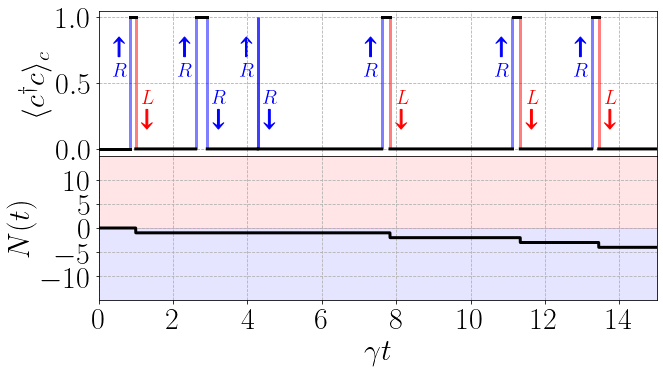

In [11]:
fs = 30
lw = 3
tfi = tm

dNHp = np.real(result.measurement[0].T[0]*dt)
dNHm = np.real(result.measurement[0].T[1]*dt)
dNCp = np.real(result.measurement[0].T[2]*dt)
dNCm = np.real(result.measurement[0].T[3]*dt)

Ih = (np.cumsum(dNHp - dNHm)*dt)[t<tfi]
Ic = (np.cumsum(dNCp - dNCm)*dt)[t<tfi]

# Creat arrows
tNHp = t[dNHp==1]
tNHm = t[dNHm==1]
tNCp = t[dNCp==1]
tNCm = t[dNCm==1]

tvs = np.sort(np.concatenate([tNHp, tNHm, tNCp, tNCm]))
tvs = tvs
tv0 = 0

# Arrow parameters
headw = 0.3
headl = 0.05
width = 0.05
length = 0.1
over = 0.5

nce = result.expect[0]
# test = nce-crt

fig = plt.figure(figsize=(10,8))

plt.subplot(3, 1,1)
    
for i, tvi in enumerate(tvs):
    
    plt.plot(t[(tv0<t)&(t<tvi)], nce[(tv0<t)&(t<tvi)], linewidth=lw, color='k', alpha=1)
    
    tv0 = tvi
    
    if tvi > tfi:
        
        break
    
    if i == len(tvs)-1:
        
        plt.plot(t[(tv0<t)&(t<tfi)], nce[(tv0<t)&(t<tfi)], linewidth=lw, color='k', alpha=1)
        break
        
    
for i in range(len(tNHp)):
    
    c1 = [1, 0, 0]
    
    plt.vlines(tNHp[i], 0, 1, color=c1, linewidth=lw, alpha=0.5)
    plt.arrow(tNHp[i]-0.3, 0.7, 0, length, head_width=headw, head_length=headl, width=width, color=c1, overhang=over)
    plt.text(tNHp[i]-0.45, 0.55, r'$L$', color=c1, fontsize=20)
    
for i in range(len(tNHm)):
    
    c2 = [1, 0, 0]
    
    plt.vlines(tNHm[i], 0, 1, color=c2, linewidth=lw, alpha=0.5)
    plt.arrow(tNHm[i]+0.3, 0.3, 0, -length, head_width=headw, head_length=headl, width=width, color=c2, overhang=over)
    plt.text(tNHm[i]+0.15, 0.35, r'$L$', color=c2, fontsize=20)
    
for i in range(len(tNCp)):
    
    c3 = [0, 0, 1]
    
    plt.vlines(tNCp[i], 0, 1, color=c3, linewidth=lw, alpha=0.5)
    plt.arrow(tNCp[i]-0.3, 0.7, 0, length, head_width=headw, head_length=headl, width=width, color=c3, overhang=over)
    plt.text(tNCp[i]-0.5, 0.55, r'$R$', color=c3, fontsize=20)
    
for i in range(len(tNCm)):
    
    c4 = [0, 0, 1]
    
    plt.vlines(tNCm[i], 0, 1, color=c4, linewidth=lw, alpha=0.5)
    plt.arrow(tNCm[i]+0.3, 0.3, 0, -length, head_width=headw, head_length=headl, width=width, color=c4, overhang=over)
    plt.text(tNCm[i]+0.1, 0.35, r'$R$', color=c4, fontsize=20)
    
plt.grid(True, linestyle='--')

plt.yticks([0, 0.5, 1], fontsize=fs)
plt.xticks(np.arange(2, 16, 2), fontsize=fs)
plt.xlabel(r'$t$', fontsize=fs)
plt.ylabel(r'$\langle c^{\dagger}c\rangle_{c}$', fontsize=fs)
plt.xlim([0, tfi])
plt.ylim([-0.05,1.05])


plt.subplot(3, 1,2)
plt.plot(t[t<tfi], (Ih)/dt, linewidth=lw, color='k', label=r'${\rm H}$')
# plt.plot(t[t<tfi], Ic, linewidth=2, color='b', label=r'${\rm C}$')

# plt.fill_between(t[t<tfi], Ih, Ic, color='b', alpha=0.1)
plt.fill_between([0, tfi], -15, 0, color='b', alpha=0.1)
plt.fill_between([0, tfi], 0, 15, color='r', alpha=0.1)

plt.grid(True, linestyle='--')

plt.xticks(np.arange(0, 18, 2), fontsize=fs)
plt.yticks(range(-10, 15, 5), fontsize=fs)
plt.xlabel(r'$\gamma t$', fontsize=fs)
plt.ylabel(r'$N(t)$', fontsize=fs)
plt.xlim([0, tfi])
plt.ylim([-15, 15])
# plt.legend(fontsize=20, loc=[0.01, 0.02])

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

# fig.savefig('quantum_jump_example_dot.png', bbox_inches='tight', dpi=300)

In [260]:
tNCp

array([ 0.757,  6.656,  9.27 , 11.284, 12.803, 26.388, 30.755, 31.712,
       32.7  , 34.746, 41.977, 51.962, 62.394, 65.505, 72.062, 75.93 ,
       77.289, 79.558, 81.426, 83.193, 86.002, 87.789, 97.632])

In [194]:
ω0 = 15
dω = 0.11
ω = np.arange(-ω0, ω0, dω)
μ = [1, -1, 1, -1]

Sω = FCSPowerSpectrumLinear(H, sc_ops, ρss, ω, sc_ops, μ, method='PD')


τ = np.linspace(0, 7, 100)
Ft =TwoTimeCorrelationSS(H, τ, sc_ops, ρss, sc_ops, μ, method='PD')

avg = 30
ωs, S = PowerSpectrum((dNHp - dNHm + dNCp  - dNCm), dt, avg)

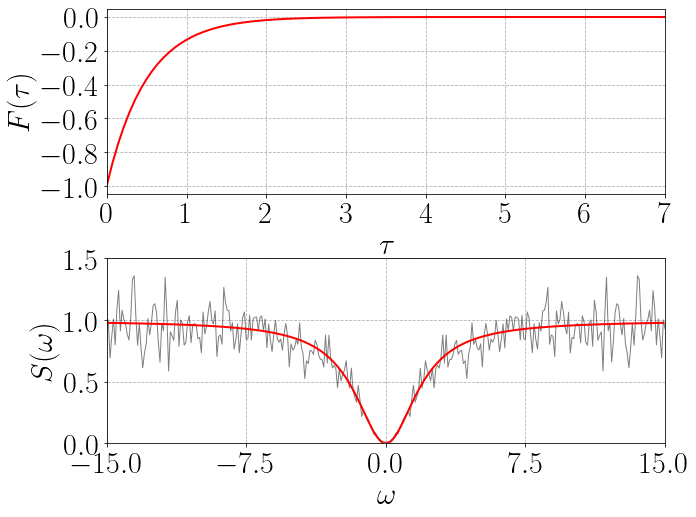

In [114]:
fig = plt.figure(figsize=(10,8))

fs=30


plt.subplot(2,1,1)
plt.plot(τ, Ft, color='r', linewidth=2)

plt.xlim([0, 7])
# plt.ylim([0.1,0.6])

plt.grid(True, linestyle='--')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.xlabel(r'$\tau$', fontsize=fs)
plt.ylabel(r'$F(\tau)$', fontsize=fs)


plt.subplot(2,1,2)
plt.plot(ωs, S, color='k', linewidth=1, alpha=0.5)
plt.plot(ω, Sω, color='r', linewidth=2)

plt.xlim([-10, 10])
plt.ylim([0.0,1.5])

plt.grid(True, linestyle='--')

plt.xticks(np.linspace(-ω0, ω0, 5), fontsize=fs)
plt.yticks(np.arange(0, 2, 0.5), fontsize=fs)

plt.xlabel(r'$\omega$', fontsize=fs)
plt.ylabel(r'$S(\omega)$', fontsize=fs)


plt.subplots_adjust(wspace=0, hspace=0.35)

plt.show()

fig.savefig('quantum_jump_example_dot_FS.png', bbox_inches='tight', dpi=300)